In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
import scrapbook as sb

C:\Users\Hakan Serpen\.conda\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'ETH'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'

In [3]:
# Parameters
from_date = "2021-12-01 00:00:00"
to_date = "2021-12-15 00:00:00"
token = "AVAX"
connection_string = "sqlite:///data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [5]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [6]:
prices['volatility'] = vol_ohlc(prices,2)


In [7]:
prices['return']=np.log(prices['close']/prices['open'])

In [8]:
prices['drawdown']=(prices.high-prices.low)/prices.high
prices['max_drawdown']=prices['drawdown'].expanding().max()

In [9]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)



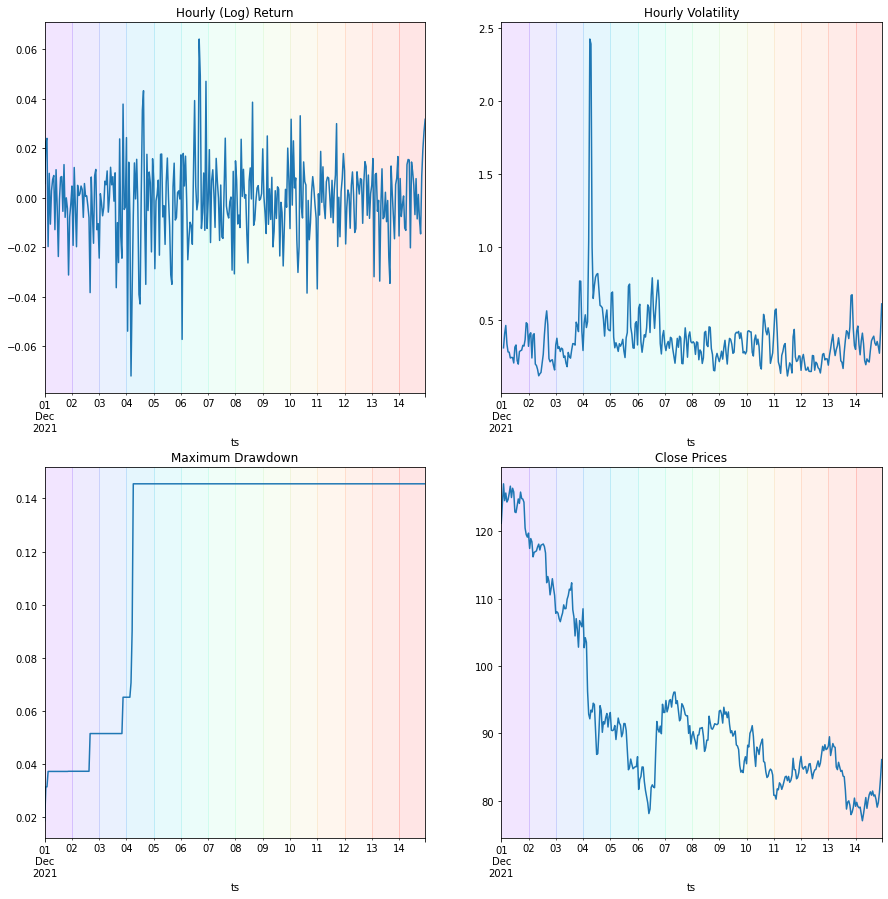

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

series_plot(prices['return'],ax=ax[0,0])
ax[0,0].title.set_text('Hourly (Log) Return')

series_plot(prices['volatility'],ax=ax[0,1])
ax[0,1].title.set_text('Hourly Volatility')

series_plot(prices['max_drawdown'],ax=ax[1,0])
ax[1,0].title.set_text('Maximum Drawdown')

series_plot(prices['close'],ax=ax[1,1])
ax[1,1].title.set_text('Close Prices')


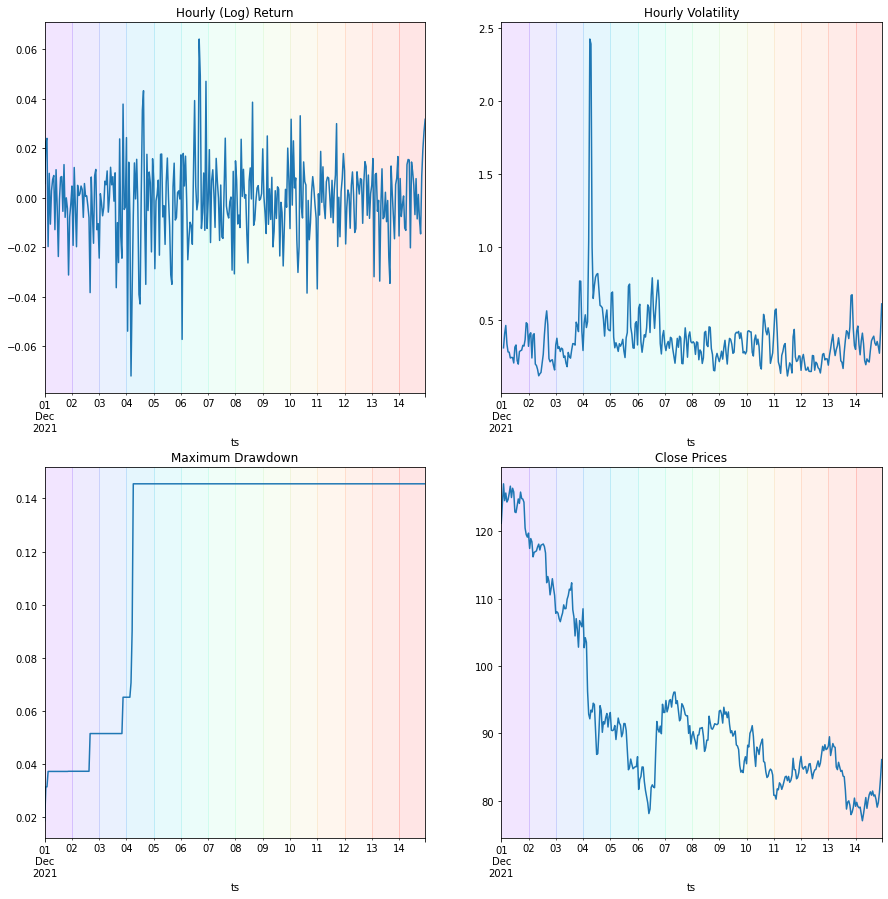

In [11]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)

In [12]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,volatility,return,drawdown,max_drawdown
ts,,,,,,,,,,,,
2021-12-01 00:00:00,120.52,122.69,120.40,121.22,58982.875,7.178868e+06,AVAX,AVAX,NaN,0.005791,0.018665,0.018665
2021-12-01 01:00:00,121.28,124.40,120.49,124.06,66106.301,8.146064e+06,AVAX,AVAX,NaN,0.022663,0.031431,0.031431
2021-12-01 02:00:00,124.07,127.18,123.88,127.09,80354.716,1.008255e+07,AVAX,AVAX,0.309495,0.024050,0.025947,0.031431
2021-12-01 03:00:00,127.07,127.59,122.84,124.59,82091.857,1.023314e+07,AVAX,AVAX,0.407763,-0.019710,0.037229,0.037229
2021-12-01 04:00:00,124.48,126.65,123.34,125.72,91628.118,1.146038e+07,AVAX,AVAX,0.462414,0.009912,0.026135,0.037229
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 19:00:00,80.17,80.41,78.40,79.01,50612.967,4.021553e+06,AVAX,AVAX,0.352867,-0.014575,0.024997,0.145482
2021-12-14 20:00:00,78.96,80.46,78.93,79.66,44537.124,3.550518e+06,AVAX,AVAX,0.319944,0.008826,0.019016,0.145482
2021-12-14 21:00:00,79.61,81.49,79.59,81.19,62792.803,5.069096e+06,AVAX,AVAX,0.272607,0.019652,0.023316,0.145482
